In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount("./drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./drive


In [2]:
!ls "./drive/My Drive/Colab Notebooks/Neural Networks HWs/ANN_HW05_time_series_prediction/checkpoints"

GRU_1layer.hdf5		  GRU_2layer_p30_ex15.hdf5  GRU_5layer.hdf5
GRU_2layer.hdf5		  GRU_2layer_p30_ex5.hdf5   LSTM_2layer.hdf5
GRU_2layer_p120.hdf5	  GRU_2layer_p30.hdf5	    LSTM_3layer.hdf5
GRU_2layer_p15.hdf5	  GRU_2layer_p60.hdf5	    LSTM_5layer.hdf5
GRU_2layer_p180.hdf5	  GRU_2layer_p90.hdf5
GRU_2layer_p30_ex10.hdf5  GRU_3layer.hdf5


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from matplotlib import pyplot as plt

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [28]:
# reading raw data
df = pd.read_csv('./drive/My Drive/Colab Notebooks/Neural Networks HWs/ANN_HW05_time_series_prediction/Iran.Khodro.csv.txt', parse_dates=['<DTYYYYMMDD>'])


H_C_values = (df['<HIGH>'] - df['<CLOSE>']).to_numpy()
O_L_values = (df['<OPEN>'] - df['<LOW>']).to_numpy()
close_values = df['<CLOSE>'].to_numpy()

# reshaping values
close_values = np.reshape(close_values, (-1, 1))
H_C_values = np.reshape(H_C_values, (-1, 1))
O_L_values = np.reshape(O_L_values, (-1, 1))

# scaling the close_values into (0, 1)
sc1 = MinMaxScaler(feature_range=(-1, 1))
sc2 = MinMaxScaler(feature_range=(-1, 1))
sc3 = MinMaxScaler(feature_range=(-1, 1))
close_values = sc1.fit_transform(close_values)
H_C_values = sc2.fit_transform(H_C_values)
O_L_values = sc3.fit_transform(O_L_values)

# fliping close_values to be in the right order of time from past to future
close_values = np.flipud(close_values)
H_C_values = np.flipud(H_C_values)
O_L_values = np.flipud(O_L_values)

# applying short-term memory filter of time-lag P and future Q to close_values
P = 30
Q = 30
memory_response = series_to_supervised(close_values, n_in=P, n_out=Q)
memory_response_deltaHC = series_to_supervised(H_C_values, n_in=P, n_out=Q)
memory_response_deltaOL = series_to_supervised(O_L_values, n_in=P, n_out=Q)

# print(memory_response)
memory_response = memory_response.to_numpy()
memory_response_deltaHC = memory_response_deltaHC.to_numpy()
memory_response_deltaOL = memory_response_deltaOL.to_numpy()


# constructing training and test sets
x_train = memory_response[:-30, :-Q]
y_train = memory_response[:-30, -Q:]

x_deltaHC_train = memory_response_deltaHC[:-30, :-Q]
y_deltaHC_train = memory_response_deltaHC[:-30, -Q:]

x_deltaOL_train = memory_response_deltaOL[:-30, :-Q]
y_deltaOL_train = memory_response_deltaOL[:-30, -Q:]


x_test = memory_response[-30:, :-Q]
y_test = memory_response[-30:, -Q:]

x_deltaHC_test = memory_response_deltaHC[-30:, :-Q]
y_deltaHC_test = memory_response_deltaHC[-30:, -Q:]

x_deltaOL_test = memory_response_deltaOL[-30:, :-Q]
y_deltaOL_test = memory_response_deltaOL[-30:, -Q:]


X_train = np.concatenate((x_train, x_deltaHC_train[:, -10:], x_deltaOL_train[:, -10:]), axis=1)
X_test = np.concatenate((x_test, x_deltaHC_test[:, -10:], x_deltaOL_test[:, -10:]), axis=1)

X_train = np.reshape(X_train, (-1, X_train.shape[1], 1))
X_test = np.reshape(X_test, (-1, X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(3685, 50, 1)
(30, 50, 1)


In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./drive/My Drive/Colab Notebooks/Neural Networks HWs/ANN_HW05_time_series_prediction/checkpoints/GRU_2layer_p30_ex10_prime.hdf5',
    monitor='val_loss',
    save_best_only=True
)

In [0]:
# initializing the GRU model
regressor = tf.keras.Sequential([
    tf.keras.layers.CuDNNGRU(units=30, input_shape=(X_train.shape[1], 1), return_sequences=True),
#     tf.keras.layers.CuDNNGRU(units=30, input_shape=(P, 1), return_sequences=True),
#     tf.keras.layers.CuDNNGRU(units=30, input_shape=(P, 1), return_sequences=True),
#     tf.keras.layers.CuDNNGRU(units=30, input_shape=(P, 1), return_sequences=True),
    tf.keras.layers.CuDNNGRU(units=15),
    tf.keras.layers.Dense(Q)
])
regressor.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [31]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [32]:
history = regressor.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_test, y_test), callbacks=[checkpoint])

Train on 3685 samples, validate on 30 samples
Epoch 1/50
3685/3685 [==============================] - 56s 15ms/sample - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.1103 - val_loss: 0.0654 - val_mean_squared_error: 0.0654 - val_mean_absolute_error: 0.2265
Epoch 2/50
3685/3685 [==============================] - 56s 15ms/sample - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0775 - val_loss: 0.0586 - val_mean_squared_error: 0.0586 - val_mean_absolute_error: 0.2067
Epoch 3/50
3685/3685 [==============================] - 55s 15ms/sample - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0729 - val_loss: 0.0606 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.2076
Epoch 4/50
3685/3685 [==============================] - 55s 15ms/sample - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0707 - val_loss: 0.0527 - val_mean_squared_error: 0.0527 - val_mean_absolute_error: 0.1933
Epoch 5/50
3685/3685 [====

In [0]:
regressor.load_weights('./drive/My Drive/Colab Notebooks/Neural Networks HWs/ANN_HW05_time_series_prediction/checkpoints/GRU_2layer_p30_ex10_prime.hdf5')

In [38]:
predictions = []
memory_buffer = np.concatenate((close_values[-30 - P:-30], H_C_values[-30-10:-30], O_L_values[-30-10:-30]), axis=0)

# print(memory_buffer.shape)
memory_buffer = np.reshape(memory_buffer, (-1, memory_buffer.shape[0], 1))
# print(memory_buffer.shape)
predictions = regressor.predict(memory_buffer)
predictions = np.reshape(predictions, (-1))

# 5% rule:
for i in range(predictions.shape[0] - 1):
    delta_prediction = (predictions[i + 1] - predictions[i]) / predictions[i]
    if delta_prediction > 0.05:
        predictions[i+1] = predictions[i] * 1.05
    elif delta_prediction < -0.05:
        predictions[i+1] = predictions[i] * 0.95

print(predictions.shape)

(30,)


In [39]:
sess = tf.Session()
test_mse = sess.run(tf.losses.mean_squared_error(close_values[-30:].T.reshape(30,), predictions))
test_mae = mean_absolute_error(close_values[-30:].T.reshape(30,), predictions)
print('test MSE: ', test_mse)
print('test MAE: ', test_mae)

test MSE:  0.004155773
test MAE:  0.04482417882494782


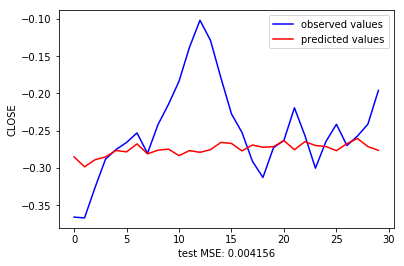

[0.032037211546845835, 0.015140107225851521, 0.013509138047754315, 0.01271549167947491, 0.012166804233757007, 0.011866588764052544, 0.011604165120281404, 0.011401706070224275, 0.011266755405730034, 0.011135550409063168, 0.010955802760329775, 0.010533474080536138, 0.010329037263687531, 0.010068730184418374, 0.009860962892620532, 0.009442150146632756, 0.009399750618035888, 0.00912257811205872, 0.009050172209958596, 0.008853742240854584, 0.008731075597726387, 0.00863181579242481, 0.00853965067242139, 0.008389604740398088, 0.008254460617758719, 0.008482333992982767, 0.008006588508889204, 0.008077834651608329, 0.007902648354224254, 0.00787243688982889, 0.007905323640265189, 0.007818077187445557, 0.007729438423169257, 0.007465426411613562, 0.0075158250459056875, 0.007226685972361969, 0.0074251624905607, 0.007179614647450823, 0.006988778240903628, 0.007657983185161448, 0.007254539920964025, 0.006327301022538153, 0.0063296673744594875, 0.006897539811141139, 0.005742472358271237, 0.005674689084

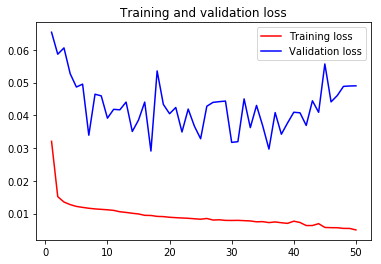

In [40]:
fig_1 = plt.figure(1)
plt.plot(close_values[-30:].T.reshape(30,), color='blue', label='observed values')
plt.plot(predictions, color='red', label='predicted values')

plt.xlabel('test MSE: %f' % test_mse)
plt.ylabel('CLOSE')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

print(loss, val_loss)
fig_2 = plt.figure(2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()